In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(ggplot2)

# setting seed
set.seed(160)

In [4]:
# reading in players.csv dataset
players_data <- read_csv("https://raw.githubusercontent.com/angelicaa-p/project_planning_stage_individual/refs/heads/main/players.csv") 
# players_data - to ensure data frame is loaded correctly

# previewing the first 10 rows to save up notebook lines 
head(players_data, 10) 


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,47


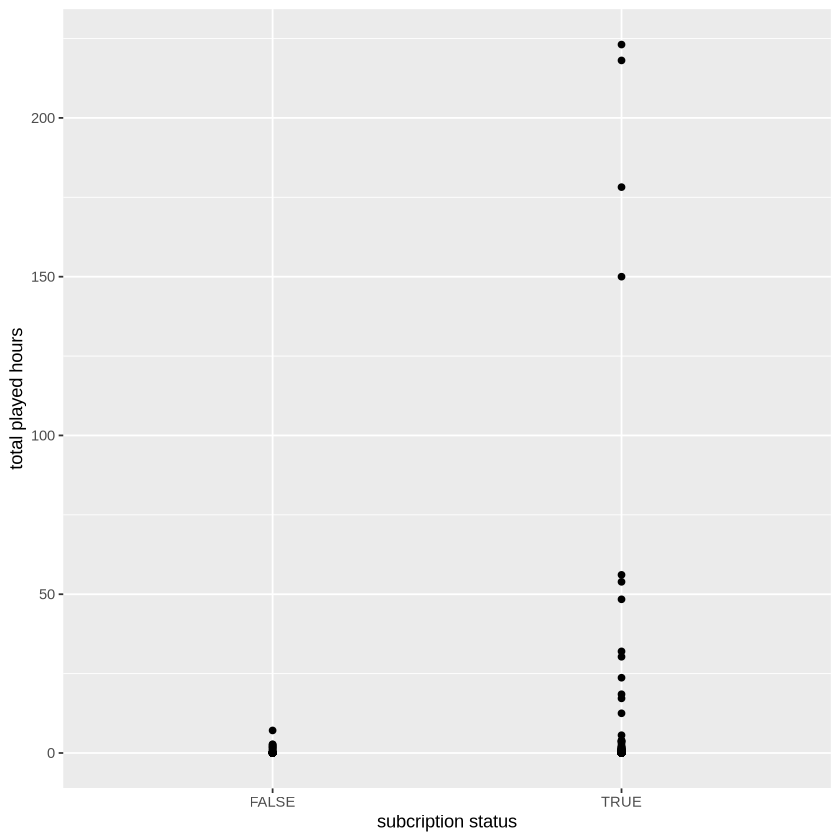

In [32]:
#selecting hours and subscription
subs_n_hours <- select(players_data, played_hours, subscribe)
#subs_n_hours

#making a plot
subs_n_hours_plot <- ggplot(subs_n_hours, aes(x = subscribe, y = played_hours)) +
    geom_point() +
        labs(x = "subcription status",
             y = "total played hours")

subs_n_hours_plot

In [34]:
#splitting the data
subs_split <- initial_split(subs_n_hours, prop = 0.75, strata = played_hours)
subs_training <- training(subs_split)
subs_testing <- testing(subs_split)

#creating recipe and spec
subs_recipe <- recipe(played_hours ~ subscribe, data = subs_training) |>    
  step_mutate(subscribe = as.factor(subscribe)) |>
  step_dummy(all_nominal_predictors()) |>
  step_scale(all_numeric_predictors()) |>
  step_center(all_numeric_predictors())

subs_recipe

subs_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

subs_spec

#creating v folds
subs_vfold <- vfold_cv(subs_training, v = 5, strata = played_hours)

subs_workflow <- workflow() |>
    add_recipe(subs_recipe) |>
    add_model(subs_spec)

subs_workflow

#results
gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

subs_results <- subs_workflow |>
                   tune_grid(resamples = subs_vfold, grid = gridvals) |>
                   collect_metrics() 




── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 1



── Operations 

• Variable mutation for: as.factor(subscribe)

• Dummy variables from: all_nominal_predictors()

• Scaling for: all_numeric_predictors()

• Centering for: all_numeric_predictors()



K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
4 Recipe Steps

• step_mutate()
• step_dummy()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1

There were issues with some computations   A: x4





In [38]:
subs_min <- subs_results |>
    filter(.metric == "rmse") |>
    slice_min(mean, n = 1)
subs_min

#tuning model to best K value
k_min <- subs_min |>
        pull(neighbors)

subs_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
        set_engine("kknn") |>
        set_mode("regression")

subs_best_fit <- workflow() |>
        add_recipe(subs_recipe) |>
        add_model(subs_best_spec) |>
        fit(data = subs_training)

subs_summary <- subs_best_fit |>
        predict(subs_testing) |>
        bind_cols(subs_testing) |>
        metrics(truth = played_hours, estimate = .pred) 

subs_summary


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
66,rmse,standard,25.96262,5,7.665781,Preprocessor1_Model14


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,22.83725026
rsq,standard,0.01709358
mae,standard,5.11612121
